In [1]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext itikz

import logging
logging.Logger.disabled=True

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import numpy as np
import matplotlib.pyplot as plt

import unittest

from pathlib import Path

from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Probe.Plot import plot
from PySpice.Math import *

import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
from schemdraw import logic

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
# definitions
        
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class JackIn(SubCircuitFactory):
    __name__ = 'jack_in'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='jack_in', value='DC 5'):
        self.__name__ = name
        super().__init__()
        self.V(1, 'n2', self.gnd, value)

class JackOut(SubCircuitFactory):
    __name__ = 'jack_out'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, name='jack_out'):
        self.__name__ = name
        super().__init__()
        self.R(1, 'n2', 'n1', R)


In [3]:
test = unittest.main(argv=[''], verbosity=0, exit=False);


----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK


"The Fastest Envelope in the West" is an ADSR design by René Schmitz. The core of this circuit is a 555 timer chip. This is a very simple build with all active parts. The envelopes can be really fast and snappy.
{: class="mt-6"} 

## construction
{: class="subtitle is-lowercase"}

the attenuverter is build around a differential amplifier with an opamp. 

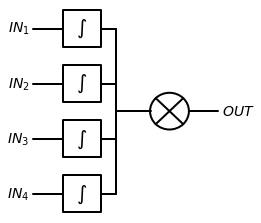

In [4]:
d = schemdraw.Drawing(inches_per_unit=0.6)

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 0*d.unit], lftlabel='$IN_4$'))
D1 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))
d.add(elm.Line( "up", l=0.75*d.unit))

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 0.5*d.unit], lftlabel='$IN_3$'))
D2 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 1*d.unit], lftlabel='$IN_2$'))
D3 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 1.5*d.unit], lftlabel='$IN_1$'))
D4 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))
d.add(elm.Line( "down", l=0.75*d.unit))
d.add(elm.Line( "right", l=d.unit*0.30))

S = d.add(dsp.Mixer(xy=[d.unit, 0.75*d.unit]))
d.add(elm.Line( "right", l=d.unit/4, rgtlabel='$OUT$'))


d.draw()


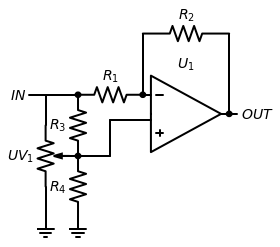

In [5]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5)

O = d.add(elm.Opamp( label='$U_1$'))

d.add(elm.Line( "left", xy=O.in1, l=d.unit/8))
R1 = d.add(elm.Resistor( "left", label='$R_1$'))
d.add(logic.Dot())    
R2 = d.add(elm.Resistor( "down", label='$R_3$'))
d.add(elm.Resistor( "down", label='$R_4$'))
d.add(elm.Ground)

L1 = d.add(elm.Line('left', l=d.unit/2, xy=R1.end))
d.add(elm.Line('down', l=d.unit/2))
RV = d.add(elm.Potentiometer('down', toplabel='$UV_1$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(elm.Ground)

d.add(elm.Line('left', l=d.unit/4, xy=L1.end, lftlabel='$IN$'))

d.add(elm.Line('right', tox=R2.end, xy=RV.tap))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/2, xy=R2.end))
d.add(elm.Line('up', l=d.unit*0.58))
d.add(elm.Line('right', l=d.unit*0.63))

d.add(logic.Dot(xy=R1.start))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Resistor('right', label='$R_2$', tox=O.out+d.unit/8))
d.add(elm.Line('down', toy=O.out))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/4, xy=O.out, rgtlabel='$OUT$'))

d.draw()

$$
\begin{array}{c}
Vout = \Bigl(1 + \frac{R2}{R1}\Bigr) \Bigl(\frac{R4}{R3+R4}\Bigr) * V2 - \Bigl(\frac{R2}{R1}\Bigr) * V1
\end{array}
$$

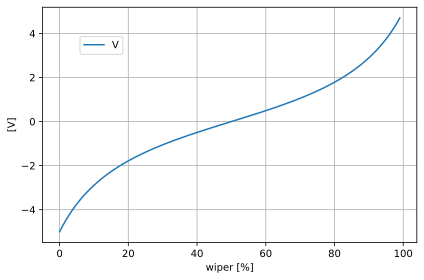

In [6]:
# calcultate the pot sweep
circuit = Circuit('attenuverter')
circuit.include(spice_library['OPA2134'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'INPUT', circuit.gnd, 'DC 5 AC 5 SIN(0 5V 1k)')

rv1 = circuit.R('RV1', 'INPUT', 'RV1out', 100@u_kΩ)
rv2 = circuit.R('RV2', 'RV1out', circuit.gnd, 100@u_kΩ)
circuit.R(3, 'INPUT', 'RV1out', 47@u_kΩ)
circuit.R(4, 'RV1out', circuit.gnd, 47@u_kΩ)

circuit.R(1, 'INPUT', 'op_neg', 100@u_kΩ)
circuit.R(2, 'op_neg', 'OUT', 100@u_kΩ)

circuit.X('op', 'OPA2134', 'RV1out', 'op_neg', '+15V', '-15V', 'OUT')

attenuverter_results = []
for s in np.arange( 1, 0, -0.01 ):
    rv1.resistance = s * 100@u_kOhm
    rv2.resistance = 100@u_kOhm - (s * 100@u_kOhm)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    attenuverter_results.append(float(analysis['OUT']))

figure, ax = plt.subplots()
ax.plot(attenuverter_results)  # input
ax.legend(('Vout [V]'), loc=(.1, .8))
ax.grid()
ax.set_xlabel('wiper [%]')
ax.set_ylabel('[V]')

plt.tight_layout()
plt.show()

the circuit of the attenuverter is based on the opamp dfferential amplifer. the two resistors at the non-inverting inputs are replaced with a potentiometer. the potentiometer is configured as a voltage divider and replace R3 and R4 from the differential amplifier. when the position of the potentiometer is adjusted, the output voltage will change or invert. at the center position  the output is zero volrs. the response to the potentiometer is linear. we can make it an centered s-curve by adding two parallel resistors (R5,R6) to the potentiometer [[2][2]].

a simulation with the resistance at RV 1 changed from 0-100%. first run is the linear result. the second run is done with the resistors R5 and R6 added. This results in a s curve. the shape of the curve can be changed with the values of the resistors.

# bom
{: class="subtitle is-lowercase"}

main circuit

{% include bom.html content="adsr-main-bom" %}



{% include callouts.html %}

{% include reports.html content="resonanz_kibot_data" %}

# *calibration*
{: class="subtitle is-lowercase"}

There is no calibration needed.

# *usage*
{: class="subtitle is-lowercase"}

the input jacks are wired to 5 volts when nothing is connected.

all channels are mixed to the out jack. when something is connected to the channel out, this channel is removed from the overall mix.

_mixer_
* connect the different channels from audio or cv sources to the in jacks.
* connect the out jack to something
* turn the pots clockwise to adjust the volume.

_attenuverter_
* connect all or a single channel. 
* when you turn the pot knob counter clockwise the signal is inverted.


# references
{: class="subtitle is-lowercase"}

- [Op Amp Differential Amplifier][1] eCircuit  Center
- [Beginners' Guide to Potentiometers][2]  Rod Elliott (ESP)

[1]: http://www.ecircuitcenter.com/Circuits/opdif/opdif.htm
[2]: https://sound-au.com/pots.htm
[10]: https://www.mouser.ch/ProductDetail/ALPS/RK09L114001T?qs=Xb8IjHhkxj78e5CYccfZWg%3D%3D
